In [1]:
import itertools as it
import os

from cliffs_delta import cliffs_delta
from iterpop import iterpop as ip
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp

from pylib import describe_effect


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: fv-az1113-403
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: perfect-tree-phylometrics
nbpath: /home/runner/work/hstrat-evolutionary-inference/hstrat-evolutionary-inference/binder/perfect-tree-phylometrics.ipynb
revision: null
session: 202fa149-6c1f-40f6-94c7-8a99022ead84
timestamp: 2024-03-23T20:58:36Z00:00


IPython==8.13.0
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==1.0.1
re==2.2.1
comm==0.2.2
logging==0.5.1.2
psutil==5.9.8
zmq==24.0.1
json==2.0.9
ipykernel==6.29.3


In [3]:
df = pd.read_csv("https://osf.io/2xuyg/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


a78d74bbfd66538a


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,36,...,287183.364388,14.043593,0,27223,1210.960392,3.210256e+06,504052.827821,NaN,NaN,NaN
1,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,37,...,348528.257947,14.320022,0,31933,1056.875368,3.230868e+06,865335.516754,NaN,NaN,NaN
2,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,6,...,229751.399043,13.258748,0,28964,1151.469136,3.171146e+06,727694.363524,NaN,NaN,NaN
3,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,20,...,228292.620676,10.335814,0,23933,1289.021227,3.339854e+06,436404.480172,NaN,NaN,NaN
4,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,34,...,245030.093866,12.832336,0,26307,1217.977803,3.237385e+06,540209.820753,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109195,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,24.562416,24.562416,1,3305,99.163609,3.242650e+04,282.320163,30.0,0.01,naive
109196,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,16,...,17.300466,17.300466,0,2923,1893.146789,6.190590e+05,250803.885040,100.0,0.01,rollback
109197,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,1,...,88.702783,88.702783,1,717008,5.744125,1.882235e+05,6.163179,100.0,1.00,rollback
109198,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,25.685331,25.685331,0,516453,28.659882,9.391270e+05,116.954707,3.0,1.00,naive


In [4]:
# phylometrics whittled down to descriptive, non-redundant set
df["colless-like index"] = df["colless_like_index"]
df["mean pairwise distance"] = df["mean_pairwise_distance"]
df["sum distance"] = df["sum_distance"]
df["mean evolutionary distinctiveness"] = df[
    "mean_evolutionary_distinctiveness"
]

phylometrics = [
    #     'diversity',
    "colless-like index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean pairwise distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "sum distance",
    # "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean evolutionary distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
    "p_niche_invasion",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [9]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess,colless-like index,mean pairwise distance,sum distance,mean evolutionary distinctiveness
0,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,36,...,1210.960392,3210256.0,504052.827821,NaN,NaN,NaN,8608.060562,1735.078375,3120820.0,1210.960392
1,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,37,...,1056.875368,3230868.0,865335.516754,NaN,NaN,NaN,9630.951765,1676.106561,3151556.0,1056.875368
2,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,6,...,1151.469136,3171146.0,727694.363524,NaN,NaN,NaN,8566.174957,1755.567603,3086073.0,1151.469136
3,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,20,...,1289.021227,3339854.0,436404.480172,NaN,NaN,NaN,7129.766332,1840.921737,3249705.0,1289.021227
4,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,34,...,1217.977803,3237385.0,540209.820753,NaN,NaN,NaN,7833.663050,1811.783902,3152357.0,1217.977803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109156,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,25,...,6.498184,212932.5,6.463885,100.0,1.0,naive,435401.851719,39.608690,259780.0,6.498184
109158,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,19,...,4.646164,152245.5,2.874790,30.0,1.0,naive,252274.501704,30.910792,210101.0,4.646164
109170,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,17,...,5.576447,182729.0,3.720116,30.0,1.0,naive,372075.510594,38.479606,250568.5,5.576447
109171,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,3,...,29.281845,959507.5,121.981043,3.0,1.0,naive,242443.400959,30.053236,959507.5,29.281845


In [10]:
# exclude extraneous variable values
df = df[(df["a"] == "collapsed-phylogeny")].copy()

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess,colless-like index,mean pairwise distance,sum distance,mean evolutionary distinctiveness
50,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,20,...,78.882446,2584820.0,1348.379396,NaN,NaN,NaN,269758.311432,32.241165,2627089.0,78.882446
51,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,4,...,81.707306,2677385.0,1030.406615,NaN,NaN,NaN,245694.126217,31.621339,2713487.0,81.707306
52,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,41,...,83.217377,2726867.0,1170.361609,NaN,NaN,NaN,229733.780163,31.319790,2726867.0,83.217377
53,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,47,...,86.538544,2835695.0,1284.142442,NaN,NaN,NaN,233461.802088,31.504697,2835695.0,86.538544
54,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,15,...,76.277557,2499463.0,1545.456043,NaN,NaN,NaN,262782.396217,32.258230,2553573.0,76.277557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104195,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,35,...,62.567078,2050198.0,699.189837,NaN,NaN,NaN,237068.370096,31.704089,2050198.0,62.567078
104196,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,30,...,54.291748,1779032.0,501.593774,NaN,NaN,NaN,230744.431058,31.961019,1779032.0,54.291748
104197,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,49,...,61.928589,2029276.0,1052.942164,NaN,NaN,NaN,236463.093766,31.770620,2029276.0,61.928589
104198,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,42,...,65.404114,2143162.0,870.762049,NaN,NaN,NaN,216331.990005,30.832036,2143162.0,65.404114


In [11]:
df["num_niches"].unique()


array([4, 1, 8])

In [12]:
df["num_islands"].unique()


array([1024,    1])

In [13]:
df["tournament_size"].unique()


array([2, 1, 4])

In [14]:
df["a"].unique()


array(['collapsed-phylogeny'], dtype=object)

In [15]:
df["regime"] = df.apply(
    lambda row: {
        (1, 1, 2, 3.0517578125e-08): "plain",
        (1, 1, 1, 3.0517578125e-08): "weak selection",
        (1, 1, 4, 3.0517578125e-08): "strong selection",
        (1, 1, 8, 3.0517578125e-08): "weak selection",
        (1024, 1, 2, 3.0517578125e-08): "spatial structure",
        (1, 4, 2, 3.0517578125e-06): "weak ecology",
        (1, 4, 2, 3.0517578125e-08): "ecology",
        (1, 8, 2, 3.0517578125e-08): "rich ecology",
    }.get(
        tuple(
            row[
                [
                    "num_islands",
                    "num_niches",
                    "tournament_size",
                    "p_niche_invasion",
                ]
            ]
        ),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["regime"]).copy()
df["regime"].unique()


array(['weak ecology', 'ecology', 'weak selection', 'plain',
       'strong selection', 'spatial structure', 'rich ecology'],
      dtype=object)

In [16]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak ecology', 'ecology', 'weak selection', 'plain',
       'strong selection', 'spatial structure', 'rich ecology'],
      dtype=object)

# Phylometrics by Regime, Perfect Data


In [17]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=(
        evolutionary_variables
        + methodological_variables
        + sensitivity_analysis_variables
        + ["regime"]
    ),
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_islands,num_niches,tournament_size,p_niche_invasion,resolution,epoch,mut_distn,regime,variable,value,phylometric
0,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak ecology,colless-like index,346237.149255,colless-like index
1,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak ecology,colless-like index,393531.329296,colless-like index
2,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak ecology,colless-like index,358279.386159,colless-like index
3,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak ecology,colless-like index,435516.244222,colless-like index
4,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak ecology,colless-like index,378408.625158,colless-like index
...,...,...,...,...,...,...,...,...,...,...,...
8395,1,1,1,3.051758e-08,NaN,0,np.random.exponential,weak selection,mean evolutionary distinctiveness,19.401215,mean evolutionary distinctiveness
8396,1,1,1,3.051758e-08,NaN,0,np.random.exponential,weak selection,mean evolutionary distinctiveness,19.637848,mean evolutionary distinctiveness
8397,1,1,4,3.051758e-08,NaN,0,np.random.exponential,strong selection,mean evolutionary distinctiveness,1.908936,mean evolutionary distinctiveness
8398,1,1,4,3.051758e-08,NaN,0,np.random.exponential,strong selection,mean evolutionary distinctiveness,1.918182,mean evolutionary distinctiveness


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png


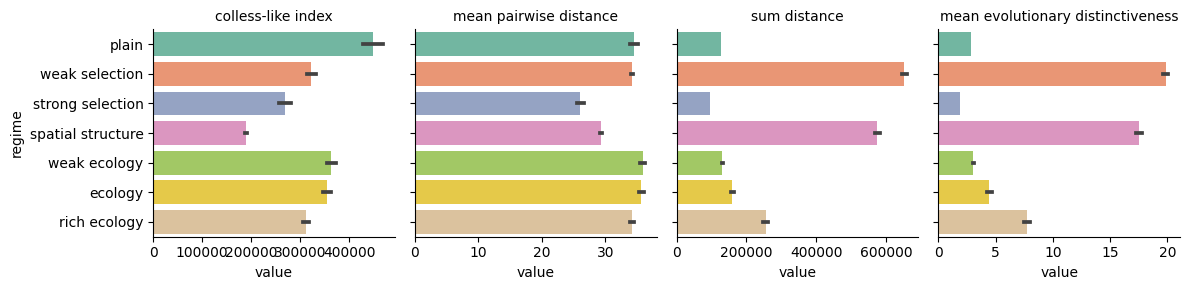

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png


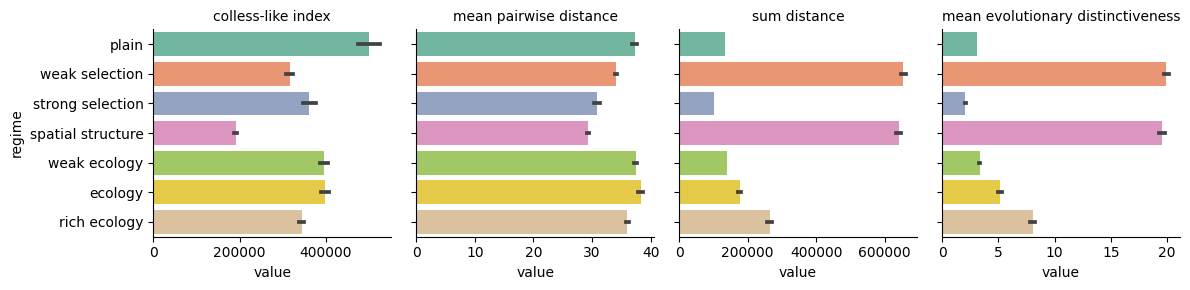

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png


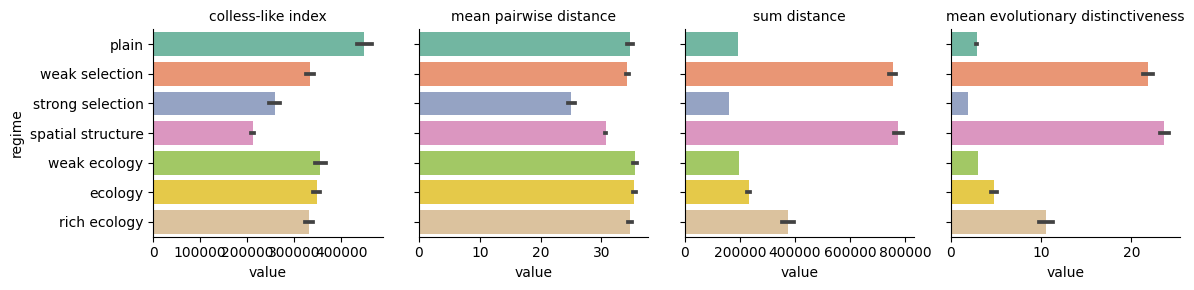

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png


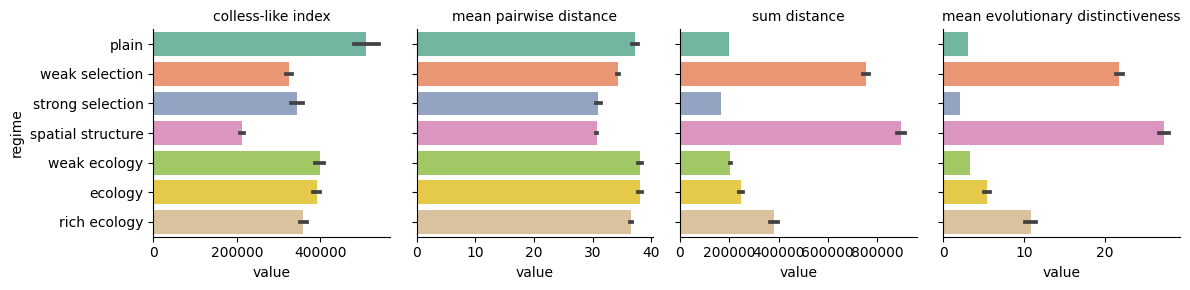

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png


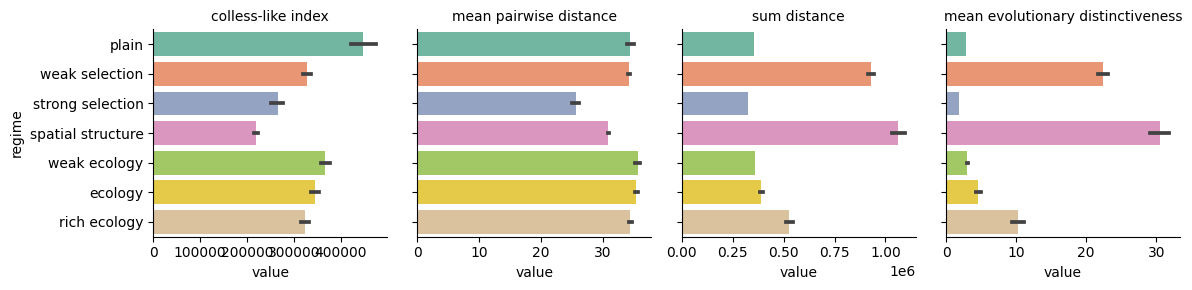

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png


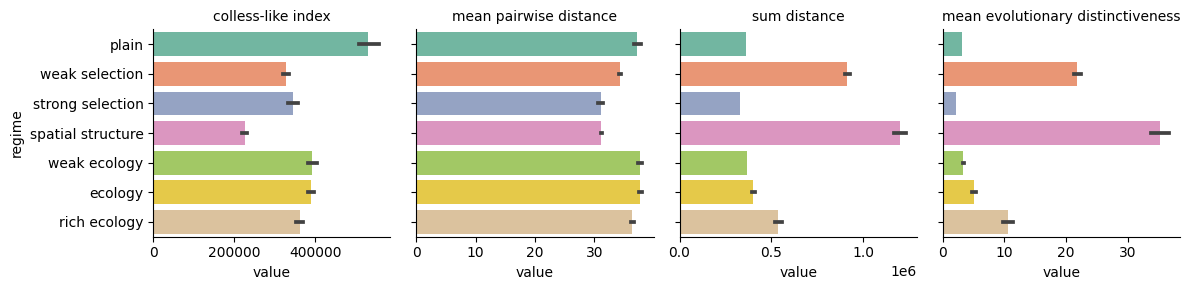

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.png


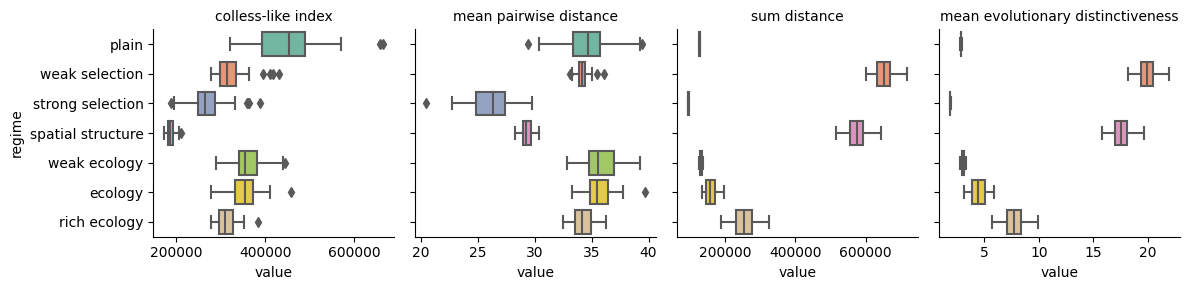

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.png


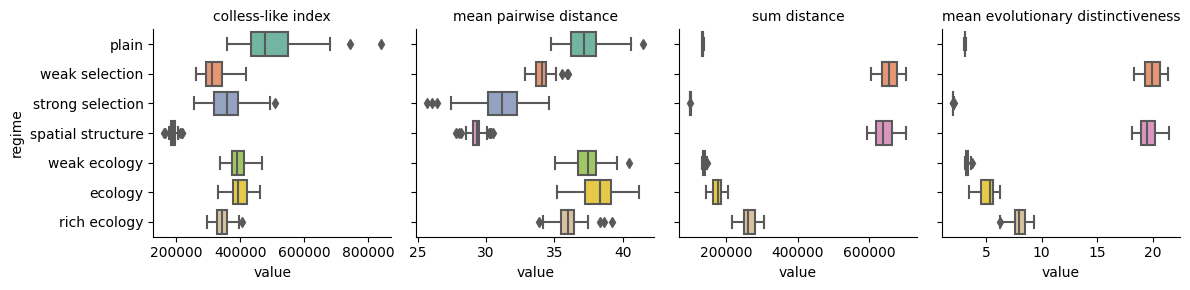

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.png


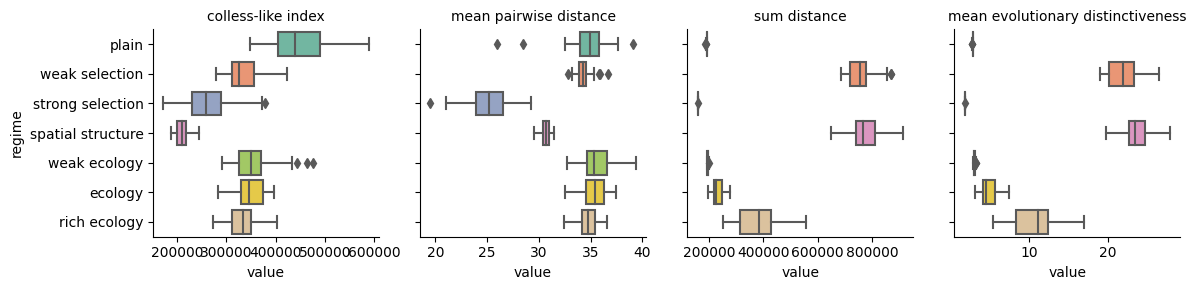

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.png


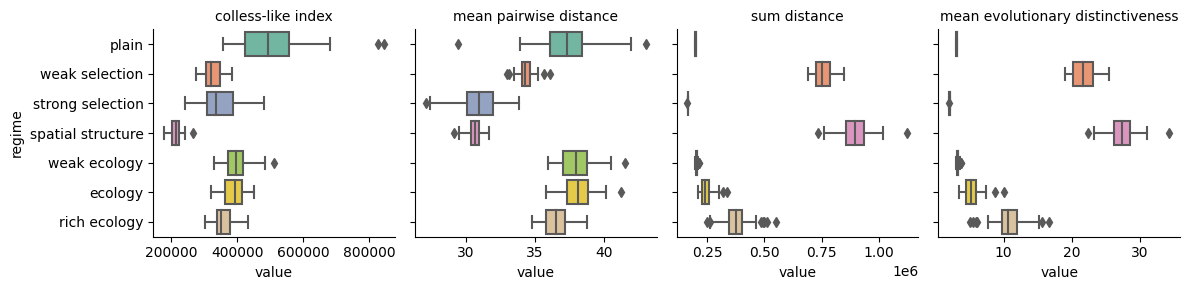

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.png


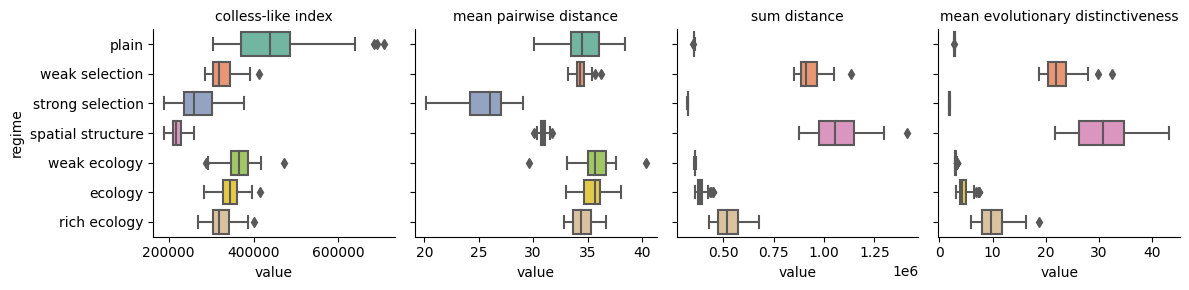

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.png


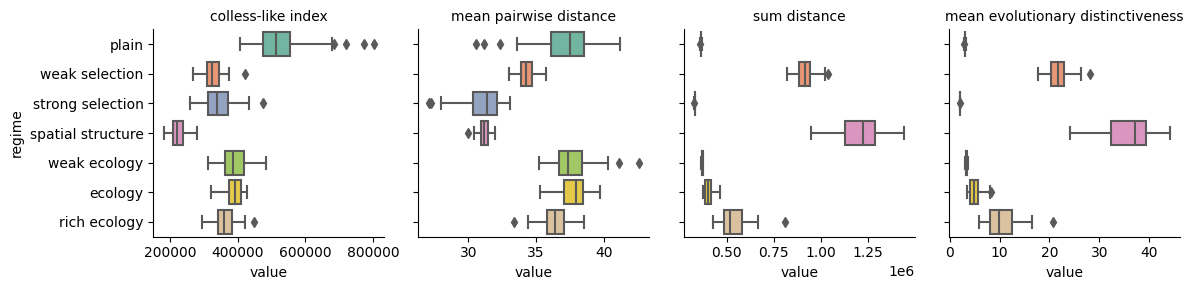

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.png


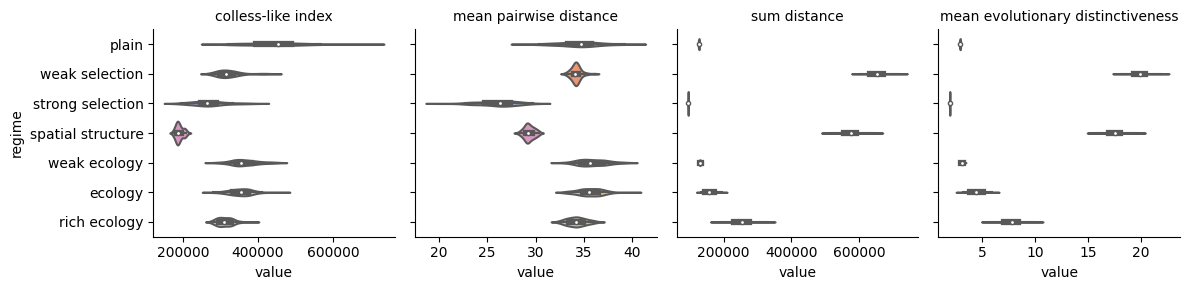

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.png


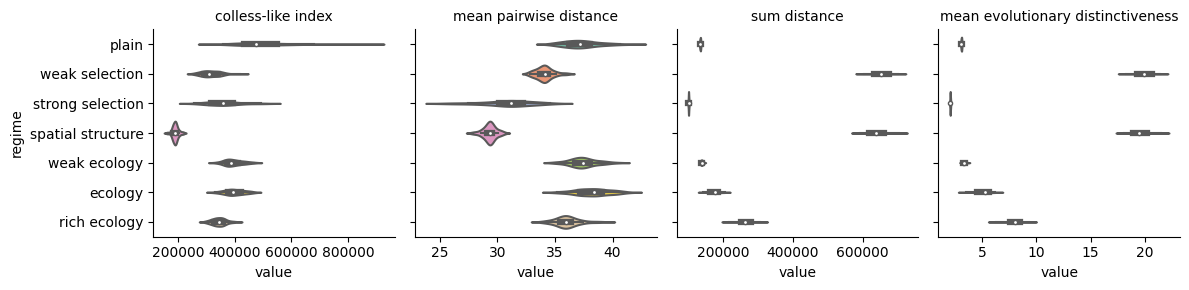

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.png


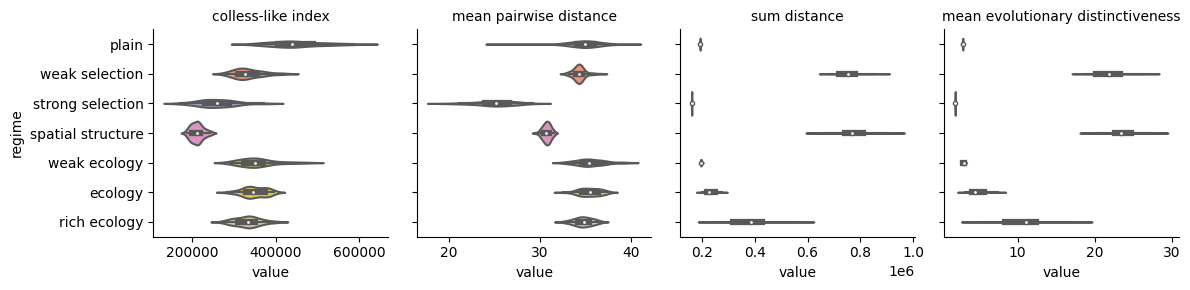

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.png


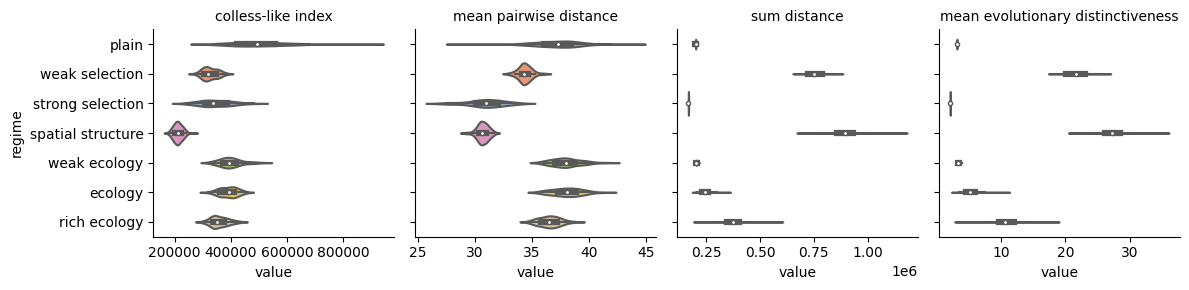

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.png


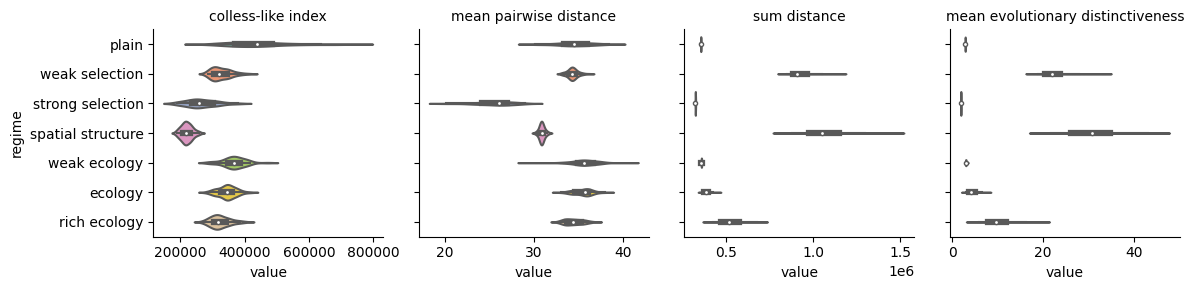

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.png


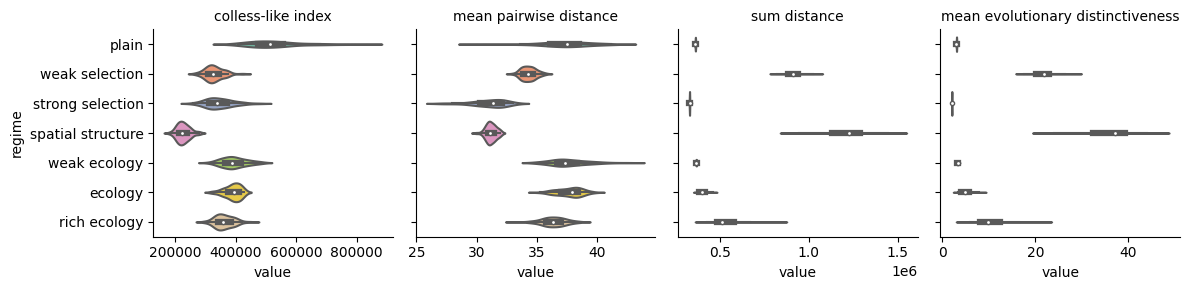

In [18]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            palette=sns.color_palette("Set2", 7),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )


# regime heatmap signatures


teeplots/epoch=0+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


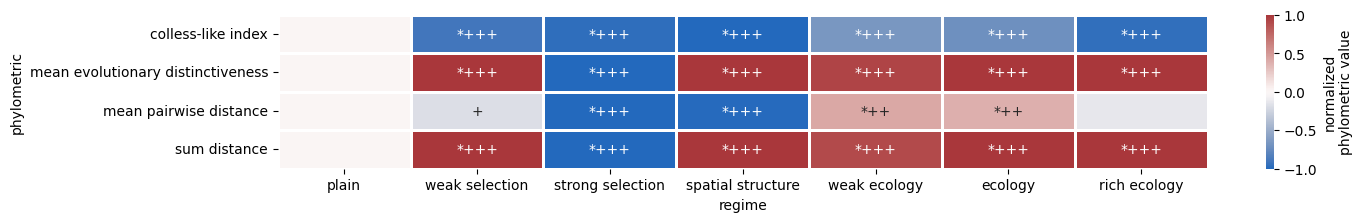

teeplots/epoch=0+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


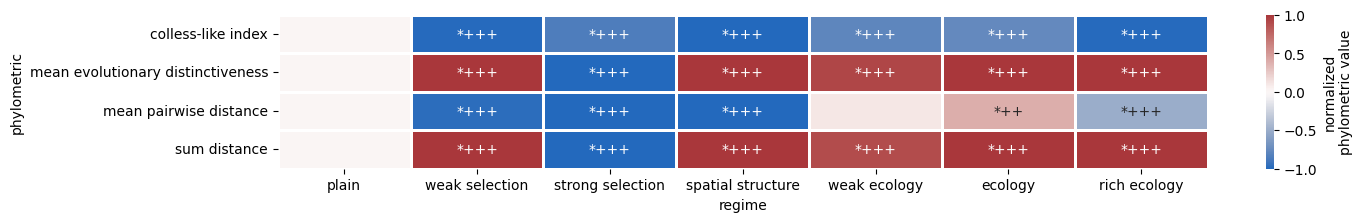

teeplots/epoch=2+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


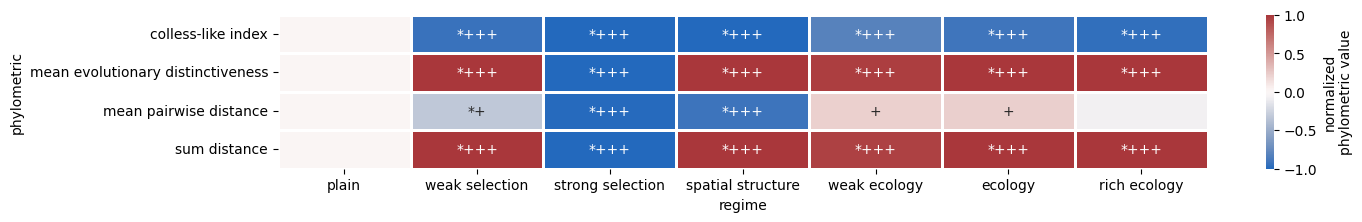

teeplots/epoch=2+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


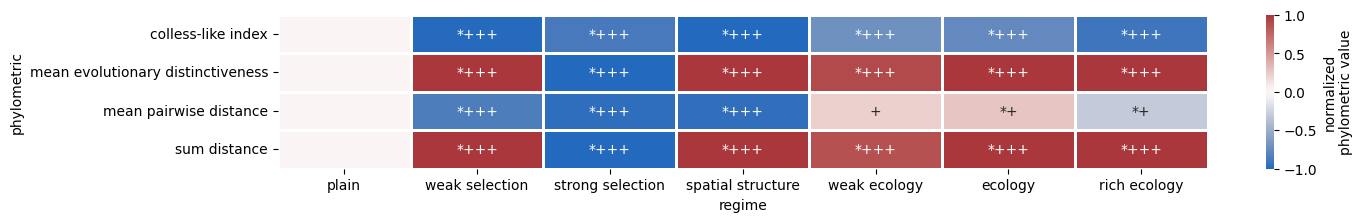

teeplots/epoch=7+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


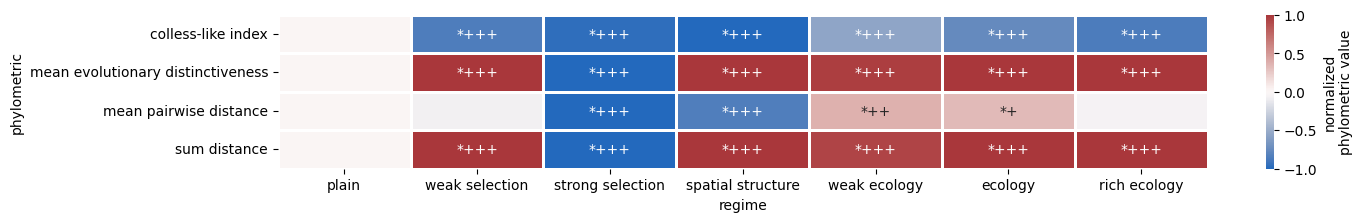

teeplots/epoch=7+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


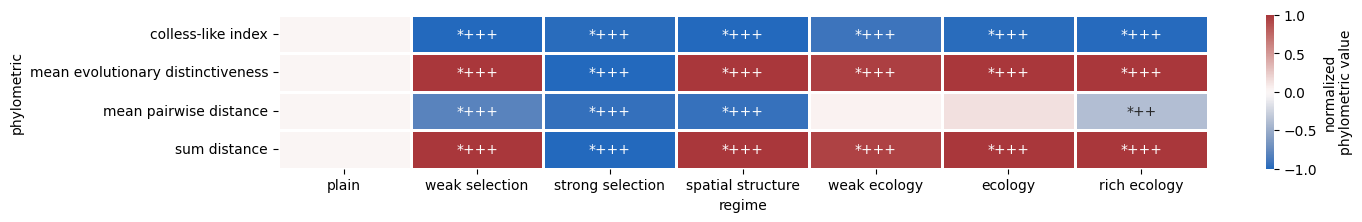

In [19]:
for (group, group_df) in df.groupby(sensitivity_analysis_variables):

    fil = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )

    melted_df = fil.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]

    def calc_cliffs_delta(group) -> float:
        phylometric, regime = group.name
        return -cliffs_delta(
            fil[fil["regime"] == "plain"][phylometric],
            fil[fil["regime"] == regime][phylometric],
        )[0]

    melted_df = melted_df.groupby(["phylometric", "regime"]).apply(
        calc_cliffs_delta,
    ).reset_index(name="value")

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    annot = []
    for metric, row in matrix.iterrows():

        def getvec(regime: str) -> np.array:
            return fil[fil["regime"] == regime][metric].to_numpy()

        annot.append(
            [
                describe_effect(getvec("plain"), getvec(regime))
                for regime in matrix.columns
            ],
        )

    tp.tee(
        sns.heatmap,
        matrix,
        annot=annot,
        fmt="",
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "normalized\nphylometric value"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
        },
        teeplot_outexclude=["fmt"],
        vmin=-1,
        vmax=1,
    )


# stats: kruskal-wallis


In [20]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-kwallis+ext=.csv",
        index=False,
    )


,n,N,phylometric,statistic,p,epoch,mut_distn
0,50,7,colless-like index,265.973064,1.576883e-54,0,np.random.exponential
1,50,7,mean pairwise distance,254.739684,3.980180e-52,0,np.random.exponential
2,50,7,sum distance,339.976537,2.187512e-70,0,np.random.exponential
3,50,7,mean evolutionary distinctiveness,340.178419,1.979817e-70,0,np.random.exponential
4,50,7,colless-like index,266.181427,1.423079e-54,0,np.random.standard_normal
5,50,7,mean pairwise distance,290.996267,6.944132e-60,0,np.random.standard_normal
6,50,7,sum distance,334.967471,2.599197e-69,0,np.random.standard_normal
7,50,7,mean evolutionary distinctiveness,335.202247,2.314532e-69,0,np.random.standard_normal
8,50,7,colless-like index,256.656035,1.549642e-52,2,np.random.exponential
9,50,7,mean pairwise distance,234.792635,7.262807e-48,2,np.random.exponential


# stats: wilcoxon all pairs


In [21]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                group_df[group_df["regime"] == regime1][phylometric],
                group_df[group_df["regime"] == regime2][phylometric],
            ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-wilcox+ext=.csv",
        index=False,
    )


,regime1,regime2,n,phylometric,statistic,p,epoch,mut_distn
0,ecology,plain,50,colless-like index,58.0,2.218011e-08,0,np.random.exponential
1,ecology,plain,50,mean pairwise distance,320.0,2.177312e-03,0,np.random.exponential
2,ecology,plain,50,sum distance,0.0,7.556929e-10,0,np.random.exponential
3,ecology,plain,50,mean evolutionary distinctiveness,0.0,7.556929e-10,0,np.random.exponential
4,ecology,rich ecology,50,colless-like index,82.0,8.212512e-08,0,np.random.exponential
5,ecology,rich ecology,50,mean pairwise distance,120.0,5.866172e-07,0,np.random.exponential
6,ecology,rich ecology,50,sum distance,0.0,7.556929e-10,0,np.random.exponential
7,ecology,rich ecology,50,mean evolutionary distinctiveness,0.0,7.556929e-10,0,np.random.exponential
8,ecology,spatial structure,50,colless-like index,0.0,7.556929e-10,0,np.random.exponential
9,ecology,spatial structure,50,mean pairwise distance,0.0,7.556929e-10,0,np.random.exponential
